# Deep Learning Classifier: Case Study on Images of Female and Male Eyes

By **Hanzholah Shobri**, 20 March 2023

Github Repository: [https://www.github.com/hanzholahs/female-and-male-eyes](https://www.github.com/hanzholahs/female-and-male-eyes)

Open this analysis on [Google Colab](https://colab.research.google.com/github/hanzholahs/female-and-male-eyes/blob/main/female_and_male_eyes.ipynb)

## 1. Background

Deep learning, a subfield of artificial intelligence, has rapidly transformed the world we live in and the way we approach life. With its capability to learn from vast amounts of data, identify patterns, and make predictions, deep learning is now being applied in a wide range of domains, from natural language processing and speech recognition to image and video recognition, recommendation systems, and even autonomous driving. As deep learning algorithms continue to improve and become more sophisticated, they are driving advancements in various fields, including healthcare, finance, transportation, and many others, revolutionizing the way we live, work, and interact with technology.

`TensorFlow` is an open-source machine learning framework developed by Google. It has become one of the most popular tools for deep learning development due to its powerful capabilities and ease of use. TensorFlow allows developers perform mathematical expressions over numerical tensor written in Python, expanding the `NumPy` capability through the ability to compute gradient automatically, run on GPUs and TPUs, distribute across machines, and be deployed to different runtimes (Chollet, 2021). This also makes it easier for companies to create and train complex neural networks and other machine learning models efficiently for the basis of their services. 

This is a report of the process of building a neural network model that could differentiate between images of male and female eyes. The dataset for the problem can be accessed via [Kaggle](https://www.kaggle.com/datasets/pavelbiz/eyes-rtte). This analysis loosely followed the universal workflow of machine learning as demonstrated by Chollet (2018).


## 2. Problem Statement

### Data Description

The dataset contains a total of 11,525 coloured images (which can be represented with the colours red, green and blue) of female and male eyes collected by Pavelbiz (2021). The images have varying resolutions (different pixel numbers for its height and weight dimensions). There are two classes or labels for the dataset: male and female. This makes it a binary classification problem as each image can only be labeled as either male or female, depending on the gender. For this analysis, the images were assumed to be representative of the population of eyes


### Hypotheses

The main hypotheses for the analysis were that genders can be predicted by using pictures of human eyes and that the available data was sufficient to provide information on the relationship between the two. These hypotheses suggest that machine learning algorithms, in this case a specific deep learning algorithm, can be used to classify male and female genders based on images of eyes. 

Furthermore, the data augmentation technique being used in the analysis was hypothesised to be able to improve the model's accuracy and generalizability. Data augmentation involves applying transformations to existing data (e.g., rotation, scaling, flipping, shifting, and adjusting brightness) to generate new data. The technique could generally prevent overfitting because the model becomes too specialised to the training data but performs poorly on unseen data. 

This analysis provided in this document aims to develop an accurate and reliable neural network model for gender classification based on images of the eyes by testing these hypotheses.


### Methods

To build the model, the analysis leveraged a set of development tools in `TensorFlow` library. The model used different types of layers, mainly the fully connected and convolutional layers, which are provided by the `tf.keras.layers.Dense` and `tf.keras.layers.Conv2D`. The performance of the model was evaluated from its accuracy in predicting the label of a given picture, and the validity of the hypotheses were evaluated based on this metric. Evaluation protocol being employed for the optimal model selection in this analysis was the hold-out validation set, which separate training data into two distinct datasets for fitting the model and evaluating the results. The optimal, final model was fitted on the complete set of the training data and assessed using the test data. The same model with identical architecture and configurations was also trained using augmented data (with randomly transformed images of the training data) and evaluated using the same testing data. The performances of both trained models was then compared.

## 3. Environment Setup

The preparation of the environment includes downloading the data using [Kaggle API](https://github.com/Kaggle/kaggle-api), importing relevant libraries, defining relevant functions to help the analysis, and setting random seed generator for better reproducibility. 

### Download data

Kaggle provides an API to access its functionalities such as competitions, datasets, and kernels. After setting up the API credential, the dataset was downloaded from the Kaggle server and stored locally. The downloaded data was in `.zip` format and extracted using `shutil.unpack_archive` function. 

In [1]:
# setup kaggle API credential
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # download data
!kaggle datasets download pavelbiz/eyes-rtte

In [3]:
# # unzip data
from shutil import unpack_archive
unpack_archive("eyes-rtte.zip", "./data")

### Import libraries

Several mainstream libraries for data analysis are used in the analysis. These libraries include `cv2` for image data manipulation, `os` for working with directories and files, `tensorflow` for building the model, `numpy` for manipulation of arrays, `pandas` for working with tabular data, and `matplotlib` for data visualisation.

In [4]:
# import relevant libraries
import cv2
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Define custom functions

In addition to downloading data and importing libraries, specific functions to help visualising the training of Deep Learning model and data augmentation were also defined here. The `plot_history` function accepts the history from the training of a model and generates line chart representing the progression of a specified metric throughout the training. The `generate_new_data` function applies several transformations randomly on an image input to generate new data.

In [5]:
def plot_history(history:tf.keras.callbacks.History, metric:str):
    """
        Plot the values of a metric during a training process
    """

    # making sure to receive the right inputs
    assert type(history) == tf.keras.callbacks.History, "`history` must be a `History` object"
    assert type(metric) == str, "`metric` must be a string"
    assert metric in history.history.keys(), f"`history` does not contain `{metric}`"
    
    # prepare data before plotting
    train_metric = history.history[metric]
    test_metric = history.history['val_' + metric]
    epochs = np.arange(len(train_metric)) + 1

    # plot data
    plt.plot(epochs, train_metric, "b", label = 'Training ' + metric)
    plt.plot(epochs, test_metric, "r", label = 'Validation/Testing ' + metric)
    plt.title('History of ' + metric)
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [6]:
def generate_new_data(img:np.ndarray, 
                      probability:float = 0.5,
                      zoom_rate:float = 0.2,
                      brightness_rate:float = 0.2,
                      shift_rate:float = 0.2):
    """
      Perform data augmentation for an input image through randomised transformations
    """
    new_img = np.copy(img)
    h, w = new_img.shape[:2]

    # flip image horizontally
    if np.random.rand() > probability:
        new_img = cv2.flip(new_img, 0)

    # rotate image
    if np.random.rand() > probability:
        # define the degree of rotation
        deg = (np.random.rand() * 90) - 45

        # define rotation matrix
        M = cv2.getRotationMatrix2D((w//2, h//2), deg, scale = 1)

        # apply rotation
        new_img = cv2.warpAffine(new_img, M, (w, h), borderMode = cv2.BORDER_REPLICATE)

    # shift image
    if np.random.rand() > probability:
        shift_h = int(np.random.rand() * shift_rate * h - shift_rate * h / 2)
        shift_w = int(np.random.rand() * shift_rate * w - shift_rate * w / 2)

        M = np.float32([[1, 0, shift_h], 
                        [0, 1, shift_w]])
        new_img = cv2.warpAffine(new_img, M, (w, h), borderMode = cv2.BORDER_REPLICATE)

    # zoom image
    if np.random.rand() > probability:
        # define new border after zooming
        border = np.array([
            0 + np.random.rand() * zoom_rate / 2 * h,
            h - np.random.rand() * zoom_rate / 2 * h - 1,
            0 + np.random.rand() * zoom_rate / 2 * w,
            w - np.random.rand() * zoom_rate / 2 * w - 1
        ]).astype(int)
        
        # crop image based on the border
        new_img = new_img[border[0]:border[1], border[2]:border[3]]
        
        # resizing to ensure identical size with the rest of the images
        new_img = cv2.resize(new_img, (h, w), interpolation = cv2.INTER_AREA)

    # adjust brightness
    if np.random.rand() > probability:
        # define random brightness change (either positive or negative)
        noise = (np.random.rand() * brightness_rate) - (brightness_rate / 2)

        # adding noise while ensuring values are between 0 and 1
        new_img = np.maximum(0, np.minimum(1, new_img + noise))
    
    return new_img

### Setup TensorFlow

The `TensorFlow` library could perform calculation using either CPU or GPU. The availability of a GPU in the system can be checked using the `tf.config.list_physical_devices` function. In addition, to increase reproducibility, the seeds for random generators are set.

In [7]:
# check tensorflow version
print(tf.__version__)

2.11.0


In [8]:
# check gpu presence
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# set seeds for random data generation
tf.keras.utils.set_random_seed(123)

## 4. Data Preparation

Image file cannot be processed directly by the `TensorFlow` model, and it needs to be converted into tensors (or multidimensional arrays). Images can be represented in many ways. In this analysis, all images are converted into an array with the shape of (height, weight, )

### Import data

The downloaded data was extracted to the `data/femaleeyes` and `data/maleeyes` folders. 

## 4. Data Preparation

### Import Data

After downloading, images were extracted to folders `data/femaleeyes` and `data/maleeyes`. These images need to be imported to `Python`. One way to this is using `cv2.imread` function that returns a `NumPy` array representing three channels of colour (red, green, and blue) using integers between 0 and 255. The images were preprocessed by converting it into greyscale, resizing it into 50x50 pixels, and scaling the numbers into floating numbers between 0 and 1. All imported and transformed images were stored in the `images` variabel. 

In addition, a new variable named `labels` was defined to store the gender class of each image based on the respective source folder. 

In [10]:
# set image resolution (35 x 35 pixels) for input data
img_size = 50

# set directories of female and male eye images
dir_f = "./data/femaleeyes/"
dir_m = "./data/maleeyes/"

# count the number of images
len_f = len(os.listdir(dir_f))
len_m = len(os.listdir(dir_m))

print(f"There are {len_f} images of female eyes.")
print(f"There are {len_m} images of male eyes.")

There are 5202 images of female eyes.
There are 6323 images of male eyes.


In [11]:
# import female eye images
img_f = np.zeros((len_f, img_size, img_size), dtype = float)
for i, img_file in enumerate(os.listdir(dir_f)):
    img = cv2.imread(os.path.join(dir_f, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img / 255
    img_f[i] = img

img_f.shape

(5202, 50, 50)

In [12]:
# import male eye images
img_m = np.zeros((len_m, img_size, img_size), dtype = float)
for i, img_file in enumerate(os.listdir(dir_m)):
    img = cv2.imread(os.path.join(dir_m, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_AREA)
    img = img / 255
    img_m[i] = img

img_m.shape

(6323, 50, 50)

In [13]:
# combine all images and define binary labels
images = np.concatenate([img_f, img_m]).reshape(-1, img_size, img_size, 1)
labels = np.concatenate([np.zeros(len(img_f), dtype = int),
                         np.ones(len(img_m), dtype = int)])

images.shape, labels.shape

((11525, 50, 50, 1), (11525,))

### Train-Test Data Splitting

The objective of Machine Learning algorithm is to buld a model that is able to generalise. That is to say that the final model needs to bo able to find patterns not only on the data on which it was trained but also unseen data. In this analysis, it was represented by the capability of a model, fitted on the train data, predicting a set of test dataset with decent performance based on a metric. 

Furthermore, to find the optimal model, one common way is to employ validation dataset which is a subset of the training data. Different models are trained using a subset of train dataset and evaluated using this validation data. This approach was used in this analysis.

The `images` dataset was firstly divided into the train and test data with the help of randomised `indices`. Afterwards, the train dataset was dividied into partial training dataset and validation dataset.

In [14]:
# split data into training and testing sets
indices = np.arange(len(images))
np.random.shuffle(indices)

train_test_split = int(0.8 * len(images))

img_train = images[indices[:train_test_split]]
lbl_train = labels[indices[:train_test_split]]

img_test  = images[indices[train_test_split:]]
lbl_test  = labels[indices[train_test_split:]]

img_train.shape, lbl_train.shape, img_test.shape, lbl_test.shape

((9220, 50, 50, 1), (9220,), (2305, 50, 50, 1), (2305,))

In [15]:
# split training data into validation and partial training sets
train_val_split  = int(0.8 * len(img_train))

partial_img_train = img_train[:train_val_split]
partial_lbl_train = lbl_train[:train_val_split]

img_val = img_train[train_val_split:]
lbl_val = lbl_train[train_val_split:]

partial_img_train.shape, partial_lbl_train.shape, img_val.shape, lbl_val.shape

((7376, 50, 50, 1), (7376,), (1844, 50, 50, 1), (1844,))

### Deleting Unused Variables

Some variables were deleted in the environment as these were not used for subsequent processes.

In [16]:
# delete excess data from runtime
del indices, images, labels
del img_f, img_m

## 5. Building the Model

The finding of the optimal model is done through two steps: (i) building the baseline model which is simple enough but able to beat basic method of prediction (in this case random prediction) and (ii) increasing the complexity of the baseline model while preventing overfitting through regularisation.

### Random Prediction

The data consists of only two classes. Hence, to be considered as a decent model, any model requires to beat randomised guesses. In this case, the random guesses will have approximately 0.5 prediction accuracy or half data correctly. This was demonstrated using a simulation by randomly generate prediction between the two labels randomly for a hundred times.

In [17]:
# predict label based on random guesses
averages = []

for _ in range(100):
    pred = np.random.randint(low = 0, high = 2, size = len(partial_lbl_train))
    averages.append(np.mean(pred == partial_lbl_train))

np.mean(averages)

0.499892895878525

### Baseline Model

The baseline model would be a simple model capable of giving sufficient performance in predicting the gender of an eye image. This was defined as a neural network model with minimum numbers of layers and units in each layer. The model contains a convolution layer, a max pooling layer, and two dense layers. The last layers has a sigmoid activation function to generate an output of either 0, if the data predicted to be a woman, or 1, if the prediction is a man. Several choices was also made regarding the model: 

* the model used RMSprop to optimize the weights of network with default parameter settings
* losses were calculated using binary crossentropy method
* the performance of the model was evaluated using accuracy as its sole metric.

In [18]:
def get_base_model():
    """Create baseline model"""
    # define model architecture for the simple model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(8, (3, 3), 
                               input_shape = (img_size, img_size, 1), 
                               activation = "relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    # compile model based on selected optimizer, loss function, and metrics
    model.compile(optimizer = "rmsprop", 
                        loss = "binary_crossentropy", 
                        metrics = ["accuracy"])

    return model

In [19]:
tf.keras.backend.clear_session()
model_base = get_base_model()

The baseline model was fitted to the partial training data and evaluated using validation data for 100 iterations of weights update through backpropagation. The model could achieve about 88.7% accuracy. This result was far beyond the random guesses method.

In [ ]:
# train the baseline model using partial training data
history = model_base.fit(partial_img_train,
                         partial_lbl_train,
                         validation_data = (img_val, lbl_val),
                         epochs = 100,
                         verbose = 0)

In [21]:
# calculate loss and accuracy
loss_1, accuracy_1 = model_base.evaluate(img_val, lbl_val, verbose = 0)
loss_1, accuracy_1

(0.43275418877601624, 0.8877440094947815)

Throughout the training, `TensorFlow` saved the values of the model's accuracy and loss. An important step of defining an optimal model is to check how the performance of the model progress during training. This was assessed using the validation data. 

As can be examined from the graphs below, the baseline model was too specialised for the data it was trained on. This is shown from both of the loss and accuracy for the training data which was lower than the values for the validation data. There was an overfitting as the model reached a peak of 89 percent of validation accuracy with no improvements after training for about 40 epochs.

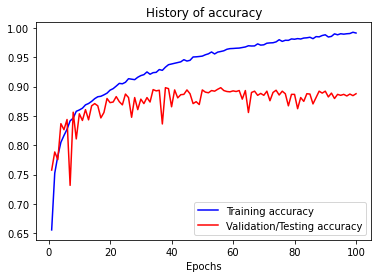

In [22]:
plot_history(history, "accuracy")

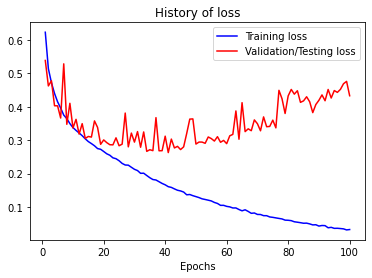

In [23]:
plot_history(history, "loss")

### Optimisation

The baseline model was supposed to be simple and worked as a basis for making additional improvements. The improvements were made by adding complexities through more and bigger layers, leveraging regularisation method,  as well as specifying different optimizer. Specifically, the optimised version of the model had more convolutional layers with more units, more units on the dense layer right before the last layer, and several dropout layer for regularisation. In addition, the Adam optimizer was selected instead of the RMSprop. The selection for the optimal architecture for the neural network was conducted by trial and errors.

In [30]:
def get_optimized_model():
    """Create optimised model"""
    # define model architecture for the optimised model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), 
                               input_shape = (img_size, img_size, 1), 
                               activation = "relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = "relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])

    # compile the model
    model.compile(optimizer = "adam",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    
    return model

In [31]:
tf.keras.backend.clear_session()
model_optimized = get_optimized_model()

The procedure for training and evaluation of the model was similar to the previous step. The only difference was that the fitting of the model was done in 300 epochs. The reason was to capture when the model start to overfit and using this as the reference for training the final data. This was a hyperparameter tuning to decide the number of epochs. The optimised model had shown some improvements in the performance as the model could reach 93.6% accuracy, about 4 percent increase compared to the baseline.

In [ ]:
# train the model using partial training data
history = model_optimized.fit(partial_img_train,
                              partial_lbl_train,
                              validation_data = (img_val, lbl_val),
                              epochs = 300,
                              verbose = 0)

In [33]:
# calculate loss and accuracy
loss_2, accuracy_2 = model_optimized.evaluate(img_val, lbl_val, verbose = 0)
loss_2, accuracy_2

(0.18001431226730347, 0.9360086917877197)

From the graphs of the model performance's history, the model had achieved 90% accuracy quite fast, or before 50 epochs. For the final model, the number of epochs was decided to be 75 or when the training accuracy started to be above the validation accuracy. Which loss value was bigger was also shifted at about 75 iteration. 

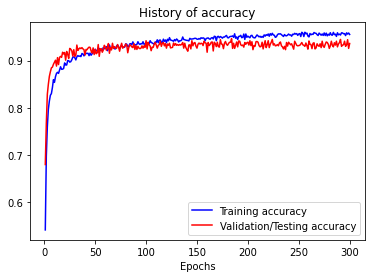

In [34]:
plot_history(history, "accuracy")

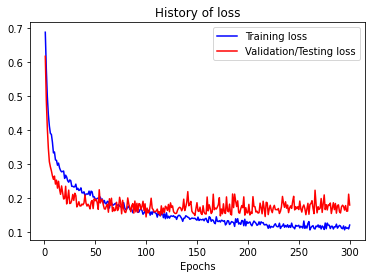

In [35]:
plot_history(history, "loss")

## 6. Training the Final Model

### Using All Training Data

The final model used the optimised model. It was trained on all training data for 75 epochs and evaluated to see how it perform on unseen data, which in this case was the test data. The model performed well with 92.1% of accuracy that is not far from the previous evaluation of the optimised model using validation data. 

In [36]:
tf.keras.backend.clear_session()
model = get_optimized_model()

In [ ]:
# train the model using all training data
history = model.fit(img_train, lbl_train, epochs = 75, verbose = 0)

In [38]:
# calculate loss and accuracy based on testing data
loss_3, accuracy_3 = model.evaluate(img_test, lbl_test, verbose = 0)
loss_3, accuracy_3

(0.1928313821554184, 0.9210411906242371)

### Data Augmentation

Several data augmentation techniques were used in the `generate_new_data` function as defined in the environment setup. Each image will be augmented with new transformed images. The number of new images for each image is specified between 3 and 7. For each technique, there is 50 percent probability that it will be applied for a given data input. The order of images in the training data was shuffled after data augmentation to reduce the effect on the training.

The performance on the training data demonstrated improved results even though it was not significant. There was only 0.5 percent improvement which might be due chance alone.

In [39]:
# set parameters for augmetation
min_n = 3
max_n = 7
prob = 0.5
rate = 0.2

# generate new data based on all images
new_images = []
new_labels = []

for i, img in enumerate(img_train):
    for _ in range(np.random.randint(min_n, max_n)):
        new_img = generate_new_data(img,
                                    probability = prob,
                                    zoom_rate = rate,
                                    brightness_rate = rate,
                                    shift_rate = rate)
        new_images.append(new_img.reshape(img_size, img_size, 1))
        new_labels.append(lbl_train[i])

# append new data to `images` and `labels`
img_train = np.concatenate([img_train, new_images])
lbl_train = np.concatenate([lbl_train, new_labels])
del new_images, new_labels

# randomised the order of train data
indices = np.arange(len(img_train))
np.random.shuffle(indices)
img_train = img_train[indices]
lbl_train = lbl_train[indices]

img_train.shape, lbl_train.shape

((50808, 50, 50, 1), (50808,))

In [40]:
tf.keras.backend.clear_session()
model = get_optimized_model()

In [ ]:
# train the model using all training data
history = model.fit(img_train, lbl_train, epochs = 75, verbose = 1)

In [42]:
# calculate loss and accuracy based on testing data
loss_4, accuracy_4 = model.evaluate(img_test, lbl_test, verbose = 0)
loss_4, accuracy_4

(0.1894570291042328, 0.9266811013221741)

# Summary

The results of the analysis has indicated that there is a relationship between genders and human's eye image. With available data, the model can predict the gender of an eye image with more than 92 percent accuracy. In addition, the data augmentation techniques employed in this analysis had provided slight increase in the performance of the model.

The analysis generated four different models that was trained and evaluated on specific datasets. It had been shown that optimisation of the model and augmentation of data could improve the performance according to the selected metric. The final losses and accuracy scores are summarised in the table below.

In [44]:
# compare losses and accuracies of all models
pd.DataFrame({
    "Model": ["Baseline", "Optimized", "Final", "Final Augmented"],
    "Train Data": ["Partial", "Partial", "Full", "Augmented"],
    "Test Data": ["Validation", "Validation", "Test", "Test"],
    "Loss": [loss_1, loss_2, loss_3, loss_4],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
})

,Model,Train Data,Test Data,Loss,Accuracy
0,Baseline,Partial,Validation,0.432754,0.887744
1,Optimized,Partial,Validation,0.180014,0.936009
2,Final,Full,Test,0.192831,0.921041
3,Final Augmented,Augmented,Test,0.189457,0.926681


## Bibliography

Chollet, F., 2021. Deep learning with Python, Second edition. ed. Manning Publications, Shelter Island.

Chollet, F., 2018. Deep learning with Python. Manning Publications, Shelter Island.

Pavelbiz, 2021, Female and male eyes. URL: https://www.kaggle.com/datasets/pavelbiz/eyes-rtte (accessed 3.13.23).
